In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt

from KAGGLE_NLP_with_disaster_tweets.model import constants, utils
from KAGGLE_NLP_with_disaster_tweets.model.attention_model import AttentionModel
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

In [33]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'
max_vocabulary_size = 20000

data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name,
                             output_sequence_length=30,
                             max_vocabulary_size=max_vocabulary_size,
                             glove_embedding_dim=200,
                             glove_url=constants.glove_url['twitter.27B'])
dataset = data_pipeline.prepare_train_dataset(include_cols=["location", "keyword"], extract_extras=True)

Getting the file: ../data/sample_submission.csv
Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7529
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3     13  000 people receive wildfires evacuation or...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                     

In [34]:
from tensorboard.plugins.hparams import api as hp

epochs = 10
log_directory = "./logs/hyperparameter_tuning_BaseModel/"

# create a dict to keep the hyperparameters
hparams = {
    hp.HParam("optimizer", hp.Discrete(["adamw"])): "adamw",
    hp.HParam("batch_size", hp.Discrete([16, 32, 64])): 32,
    hp.HParam("learning_rate", hp.RealInterval(1e-5, 1e-3)): 1e-4,
    hp.HParam("class_weights", hp.Discrete(["none", "balanced"])): "balanced",
    hp.HParam("dropout", hp.Discrete([0.1, 0.9])): 0.4
}
# easier to manage hyperparameters with this wrapper class
hyperparameter_manager = utils.HyperparameterManager(hparams=hparams)

In [35]:
model = None
use_glove_embeddings = True

if use_glove_embeddings:
    model = AttentionModel(
        embedding_dim=data_pipeline.glove_embedding_dim,
        hidden_dim=256,
        num_heads=4,
        vocabulary_size=data_pipeline.vocabulary_size,
        num_classes=2,
        epochs=10,
        maximum_position_encoding=data_pipeline.input_vectorizer.get_config()["output_sequence_length"],
        embeddings_initializer=data_pipeline.build_embeddings_initializer(),
        hparam_manager=hyperparameter_manager,
        batch_pipeline=BatchPipeline(dataset, hyperparameter_manager.batch_size))
else:
    model = AttentionModel(
        embedding_dim=128,
        hidden_dim=256,
        num_heads=4,
        vocabulary_size=data_pipeline.vocabulary_size,
        num_classes=2,
        epochs=10,
        maximum_position_encoding=data_pipeline.input_vectorizer.get_config()["output_sequence_length"],
        hparam_manager=hyperparameter_manager,
        batch_pipeline=BatchPipeline(dataset, hyperparameter_manager.batch_size))

Loading the file: glove.twitter.27B.200d.txt 

Found 1193514 word vectors 

Converted 12888 words, and missed 4786 words.


In [36]:
balanced_class_weights = utils.get_balanced_class_weights(data_pipeline.dataframe)

## Sanity Check: Overfit the model

In [37]:
debugging_dataset = dataset.take(2).batch(2)
model.test_model(debugging_dataset, 10)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6761 - accuracy: 0.5000 - val_loss: 0.5948 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 154ms/step - loss: 0.6521 - accuracy: 0.5000 - val_loss: 0.5919 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 152ms/step - loss: 0.6669 - accuracy: 0.5000 - val_loss: 0.5861 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 136ms/step - loss: 0.5554 - accuracy: 0.5000 - val_loss: 0.5774 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 150ms/step - loss: 0.4934 - accuracy: 1.0000 - val_loss: 0.5661 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 136ms/step - loss: 0.6221 - accuracy: 0.5000 - val_loss: 0.5520 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 167ms/step - loss: 0.5019 - accuracy: 0.5000 - val_loss: 0.5355 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=======

In [38]:
accuracy, precision, recall, f1, predictions1 = model.fit_and_evaluate(class_weights=balanced_class_weights, log_directory=log_directory)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

None starting...
Epoch 1/10
141/141 [==============================] - 7s 38ms/step - loss: 0.5467 - accuracy: 0.7117 - val_loss: 0.5229 - val_accuracy: 0.7673
Epoch 2/10
141/141 [==============================] - 4s 29ms/step - loss: 0.4474 - accuracy: 0.8003 - val_loss: 0.5100 - val_accuracy: 0.7726
Epoch 3/10
141/141 [==============================] - 5s 34ms/step - loss: 0.4161 - accuracy: 0.8169 - val_loss: 0.4898 - val_accuracy: 0.7899
Epoch 4/10
141/141 [==============================] - 5s 33ms/step - loss: 0.3919 - accuracy: 0.8291 - val_loss: 0.4829 - val_accuracy: 0.8005
Epoch 5/10
141/141 [==============================] - 5s 34ms/step - loss: 0.3730 - accuracy: 0.8404 - val_loss: 0.4963 - val_accuracy: 0.7992
Epoch 6/10
141/141 [==============================] - 5s 35ms/step - loss: 0.3557 - accuracy: 0.8502 - val_loss: 0.5089 - val_accuracy: 0.7999
Epoch 7/10
141/141 [==============================] - 5s 36ms/step - loss: 0.3433 - accuracy: 0.8559 - val_loss: 0.5246 - val

## Visualize accuracy and loss

In [39]:
history = model.history

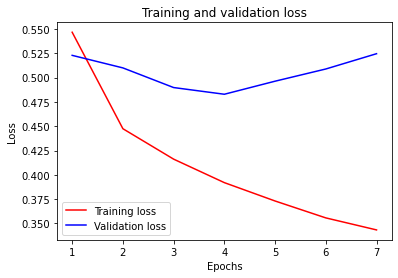

In [40]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

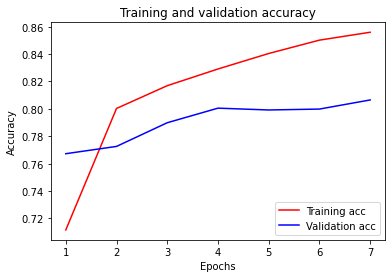

In [41]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()